In [ ]:
from google.colab import drive
import os

mount='/content/gdrive'
drive.mount(mount)

# Switch to the directory on the Google Drive that you want to use
drive_root = mount + "/My Drive/large-language-models-main"
%cd $drive_root

In [2]:
from diffusers import DiffusionPipeline
import torch

/home/rkd43/Teaching/large-language-models/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16, use_safetensors=True, variant="fp16"
)

pipe.to("cuda")

In [9]:
prompt = "A samurai cat"

images = pipe(prompt=prompt).images

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 11.54it/s]


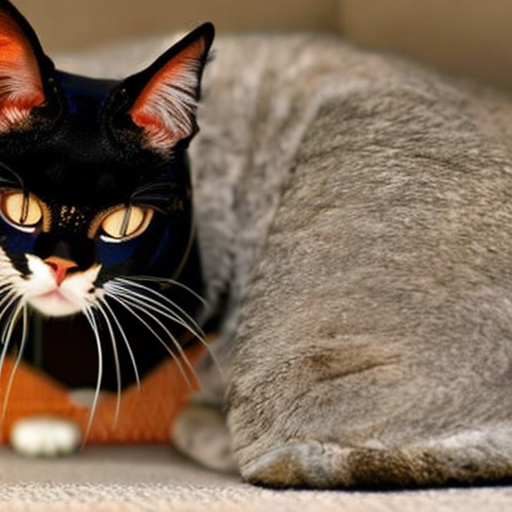

In [11]:
images[0]

In [3]:
# load both base & refiner
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
base.to("cuda")

refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")

# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 40
high_noise_frac = 0.8

prompt = "A photorealistic samurai cat with a sword and fire in the background"

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 18.32it/s]


In [4]:
# run both experts
image_base = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images

image_final = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image_base,
).images[0]

100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


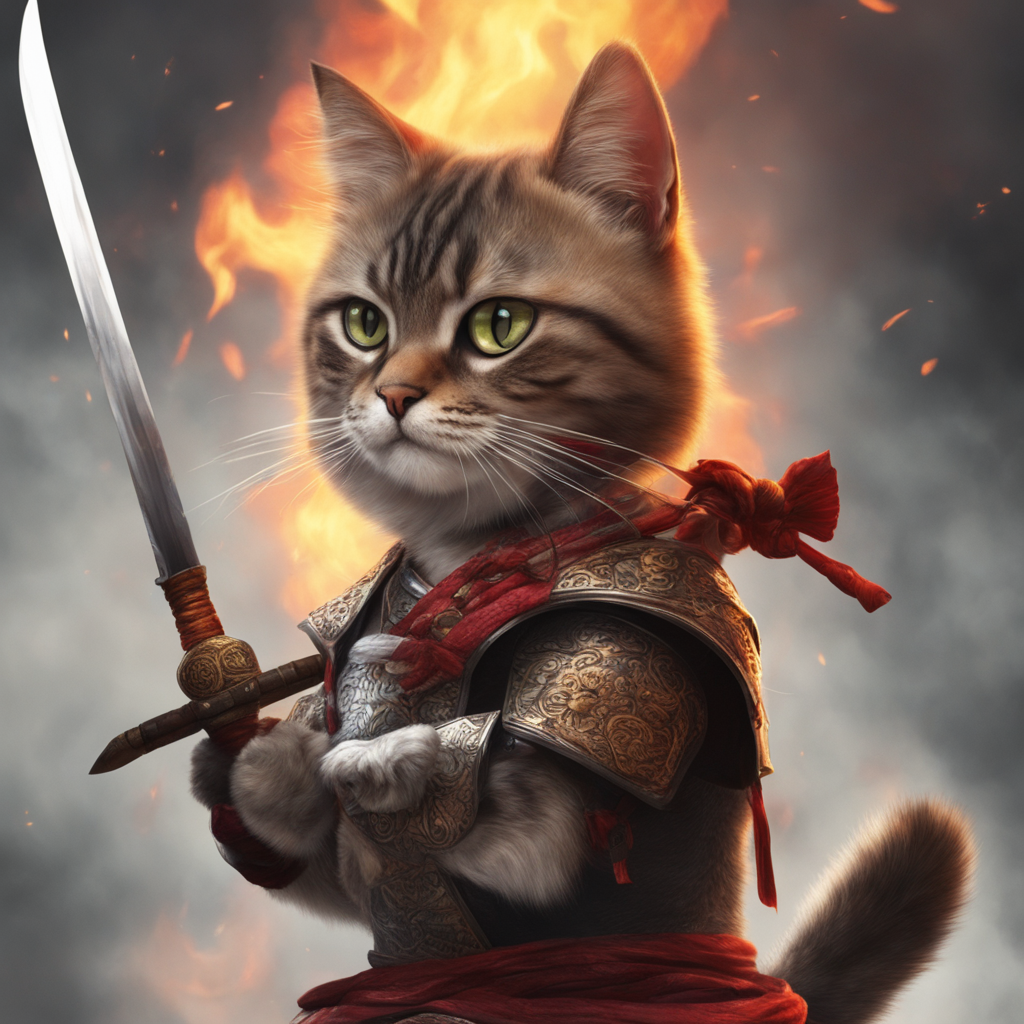

In [5]:
image_final